In [ ]:
!pip install pytorch-lightning
import pytorch_lightning as pl
print(pl.__version__)

     |████████████████████████████████| 923 kB 5.2 MB/s 
     |████████████████████████████████| 636 kB 40.5 MB/s 
     |████████████████████████████████| 829 kB 43.0 MB/s 
     |████████████████████████████████| 282 kB 38.9 MB/s 
     |████████████████████████████████| 119 kB 46.9 MB/s 
     |████████████████████████████████| 1.3 MB 32.8 MB/s 
     |████████████████████████████████| 294 kB 46.9 MB/s 
     |████████████████████████████████| 142 kB 47.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=fd13a66d2465cd320ac0a0312d6f90554280fb29a248a46187f897837ee2a0ad
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found existing installation: future 0.16.0
    Uninstalling future-0

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

import math
import subprocess as sub
import pathlib
import re
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd


In [ ]:
class ResponseDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=32):
        self.batch_size = batch_size
        # save the dataframe, in case we need it
        self.df = None

        # full dataset
        self.ds = None
        # split datasets
        self.train_ds = None
        self.val_ds = None

        super(ResponseDataModule, self).__init__()

    def prepare_data(self):
        # load from csv
        self.df = pd.read_csv("drive/MyDrive/AML/policies_onehot_full_absolute_R.csv")

        df = self.df.copy()
        df.pop("country")

        y = df.pop("reproduction_rate").to_numpy()
        x = df.to_numpy()

        # drop index
        x = x[:, 1:]

        x = torch.Tensor(x)
        y = torch.Tensor(y).unsqueeze(-1)

        self.ds = TensorDataset(x, y)

    def setup(self, stage=None):
        # perform random split with fractional lengths
        train = int(0.9 * len(self.ds))
        val = len(self.ds) - train

        self.train_ds, self.val_ds = random_split(self.ds, [train, val])

    def train_dataloader(self):
        return DataLoader(self.train_ds, shuffle=True, num_workers=2, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_ds, num_workers=2, batch_size=self.batch_size)


In [ ]:
class ElementwiseProductLayer(nn.Module):
    def __init__(self, n_policies):
        super(ElementwiseProductLayer, self).__init__()
        self.weights = nn.Parameter(torch.Tensor(1, n_policies))

    def forward(self, x):
        return x * self.weights


class PolicyTrackerSingle(pl.LightningModule):
    def __init__(self):
        super(PolicyTrackerSingle, self).__init__()

        # placeholder mean R0 taken from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7751056/
        # could be country-dependent, this should definitely be improved
        self.R0 = 3.28

        self.n_policies = 46
        self.n_other = 2

        self.model = nn.Sequential(
            nn.Linear(self.n_policies + self.n_other, 1024),
            nn.PReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(1024, 512),
            nn.PReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, 256),
            nn.PReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 256),
            nn.PReLU(),
            nn.Linear(256, self.n_policies),
        )

        # initialize weights
        for module in self.model.modules():
            if type(module) is nn.Linear:
                data = module.weight.data
                nn.init.normal_(data, 0, 2 / data.numel())

        # self.elementwiseProduct = ElementwiseProductLayer(self.n_policies)
        # nn.init.normal_(self.elementwiseProduct.weights.data, 1, 1)

        self.model2 = nn.Linear(1, 1, bias=False)


        self.loss = nn.MSELoss()

    # TODO: somehow this predicts 0, all the time
    def forward(self, x):
        # predict the effect p of single policies on the R value
        p = self.model(x)
        # p = self.elementwiseProduct(x[:,:-2])

        # take the product
        m = torch.prod(torch.exp(-p), dim=-1).unsqueeze(dim=-1)

        # scale with R0
        # return self.R0 * m
        res = self.model2(m)
        return res

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=30, factor=0.3, threshold=0.05,
                                                                  verbose=True)
        return dict(optimizer=optimizer, lr_scheduler=lr_scheduler, monitor="val_loss")

    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self(x)
        loss = self.loss(yhat, y)

        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        yhat = self(x)
        loss = self.loss(yhat, y)

        self.log("val_loss", loss)

        return loss



In [ ]:
dm = ResponseDataModule()
pt = PolicyTrackerSingle()

callbacks = [
    # save model with lowest validation loss
    pl.callbacks.ModelCheckpoint(monitor="val_loss"),
    # stop when validation loss stops decreasing
    pl.callbacks.EarlyStopping(monitor="val_loss", patience=10),
]

logger = TensorBoardLogger(save_dir="drive/MyDrive/AML/lightning_logs", name="", default_hp_metric=False, log_graph=True)

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=callbacks,
    logger=logger,
    gpus=1,
)

trainer.fit(pt, datamodule=dm)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1295: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loggers/tensorboard.py:237: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  UserWarning,

  | Name   | Type       | Params
--------------------------------------
0 | model  | Sequential | 783 K 
1 | model2 | Linear     | 1     
2 | loss   | MSELoss    | 0     
--------------------------------------
783 K     Trainable params
0         Non-trainable params
783 K     Total params
3.136     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:

def plot_country(model, df, country="Germany", randomize_policies=False):
    df = df[df["country"] == country]

    df.pop("country")

    y = df.pop("reproduction_rate").to_numpy()
    x = df.to_numpy()

    # drop index
    x = x[:, 1:]

    x = torch.Tensor(x)
    y = torch.Tensor(y).unsqueeze(-1)

    if randomize_policies:
        # this is useful to check how much the model relies on this vs other features
        random_x = torch.randint(0, 1, size=(x.shape[0], model.n_policies)).to(torch.float64)
        x[:, :model.n_policies] = random_x

    predicted = model(x).detach().cpu().numpy()

    ax = plt.gca()
    ax.plot(y, label="Actual")
    ax.plot(predicted, label="Predicted")
    ax.set_xlabel("Time")
    ax.set_ylabel("R")
    ax.set_title(country)
    ax.legend()
    print(ax.get_ylim())


def plot_countries(model, countries=("Germany",), randomize_policies=False):
    df = pd.read_csv("drive/MyDrive/AML/policies_onehot_full_absolute_R.csv")

    nrows = int(round(np.sqrt(len(countries))))
    ncols = len(countries) // nrows

    plt.figure(figsize=(6 * ncols + 1, 6 * nrows))

    axes = []
    for i, country in enumerate(countries):
        axes.append(plt.subplot(nrows, ncols, i + 1))
        plot_country(model, df, country, randomize_policies=randomize_policies)

    # set all ylims equal
    ylims = []
    for ax in axes:
        ylims.extend(ax.get_ylim())

    ylims = [min(ylims), max(ylims)]
    for ax in axes:
        ax.set_ylim(ylims)

    plt.show()

(-0.05474755950272084, 3.27117833532393)
(-0.06024756617844107, 3.386678475514054)
(-0.07724756188690662, 3.7436783853918314)
(-0.0012475628405809458, 2.147678405418992)
(-0.021247567608952522, 2.5676785055547953)
(-0.007747568562626844, 2.284178525581956)


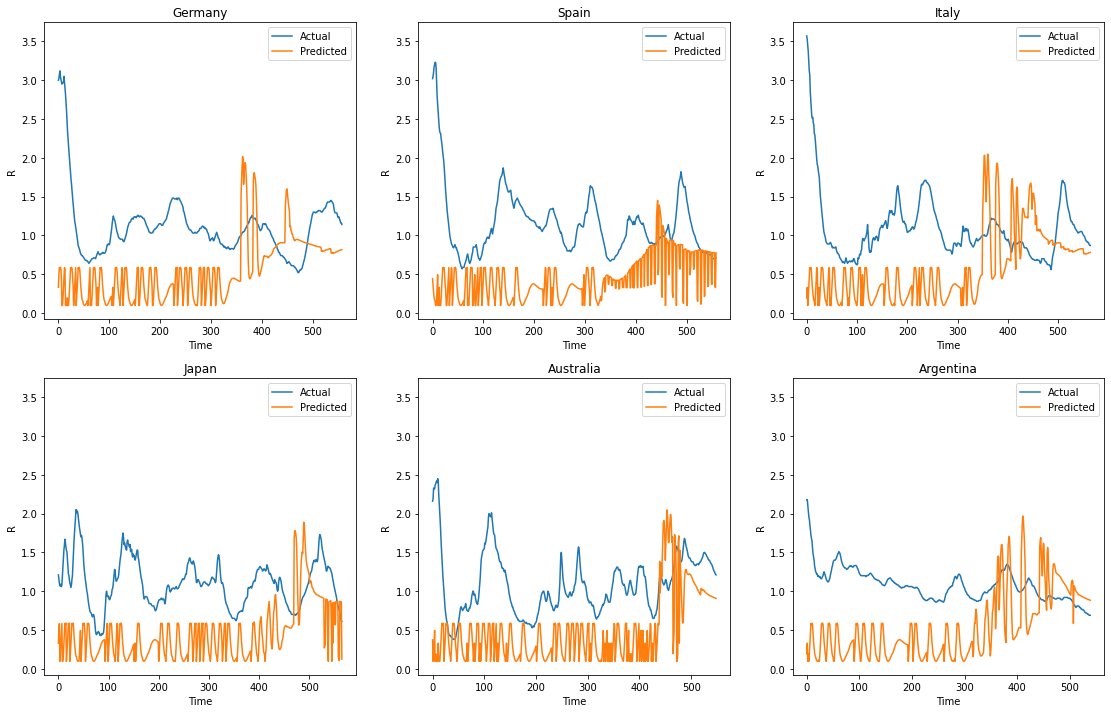

(0.38909724950790403, 3.2689573407173156)
(0.4311707645654678, 3.4854137867689134)
(0.4095000058412552, 3.7204999297857286)
(0.349000009894371, 2.1309999495744707)
(0.276499992609024, 2.55350005030632)
(0.6154999941587448, 2.2545000702142715)


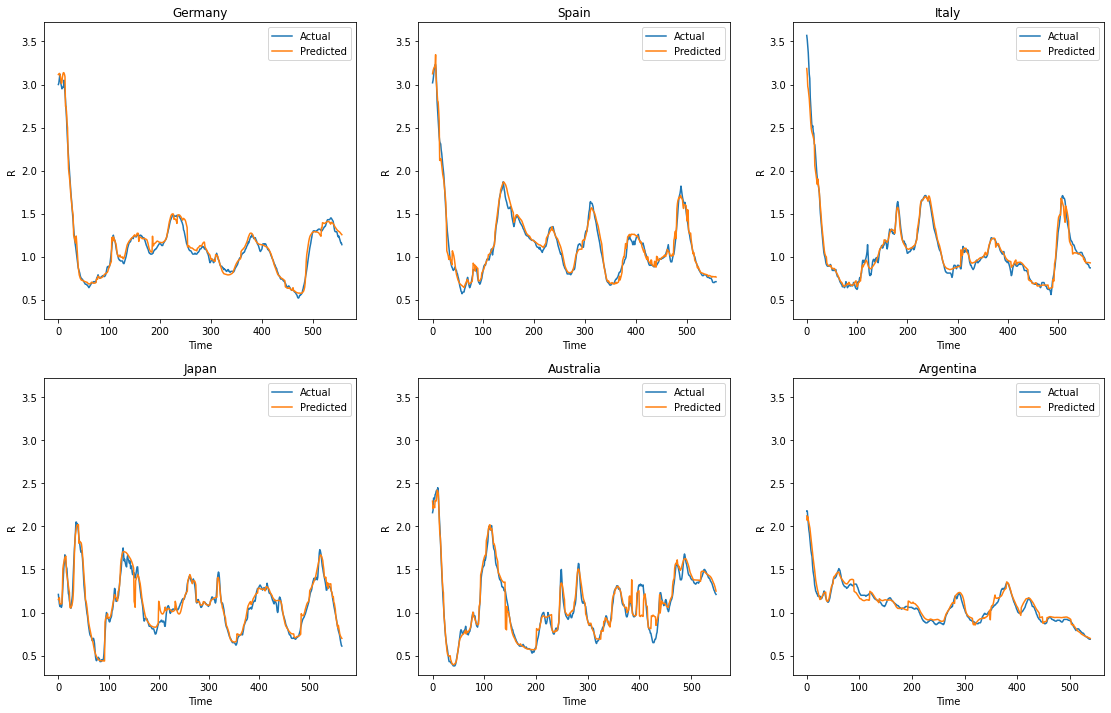

In [ ]:
pt.eval()

countries = ("Germany", "Spain", "Italy", "Japan", "Australia", "Argentina")

plot_countries(model=pt, countries=countries, randomize_policies=True)
plot_countries(model=pt, countries=countries, randomize_policies=False)


In [ ]:
def plot_single_policy(model, vaccination):
    model.eval()
    means = np.zeros(model.n_policies+1)
    stds = np.zeros(model.n_policies+1)
    num_days = 15
    for policy_index in range(-1, model.n_policies):
        x = torch.zeros(size=(num_days, model.n_policies + 2))
        if policy_index >= 0:
            x[:, policy_index] = torch.ones(num_days)
        x[:, -2] = torch.arange(start=0, end=num_days)
        x[:, -1] = vaccination * torch.ones(num_days)
        
        predicted = model(x)

        diff = predicted[1:] - predicted[:-1]
        
        means[policy_index+1] = torch.mean(diff)
        stds[policy_index+1] = torch.std(diff)
        
    plt.figure(figsize=(19,12))
    plt.errorbar(np.arange(model.n_policies+1), means, yerr=stds, fmt=".")
    xticks = [
        "no", "C1 1", "C1 2", "C1 3", "C2 1", "C2 2", "C2 3", "C3 1", "C3 2", "C4 1", "C4 2", "C4 3", "C4 4", "C5 1", "C5 2", "C6 1", "C6 2", "C6 3", "C7 1", "C7 2", "C8 1", "C8 2", "C8 3", "C8 4", "E1 1", "E1 2", "E2 1", "E2 2", "H1 1", "H1 2", "H2 1", "H2 2", "H2 3", "H3 1", "H3 2", "H6 1", "H6 2", "H6 3", "H6 4", "H7 1", "H7 2", "H7 3", "H7 4", "H7 5", "H8 1", "H8 2", "H8 3",
    ]
    plt.xticks(np.arange(model.n_policies+1), xticks, rotation='vertical')
    plt.show()


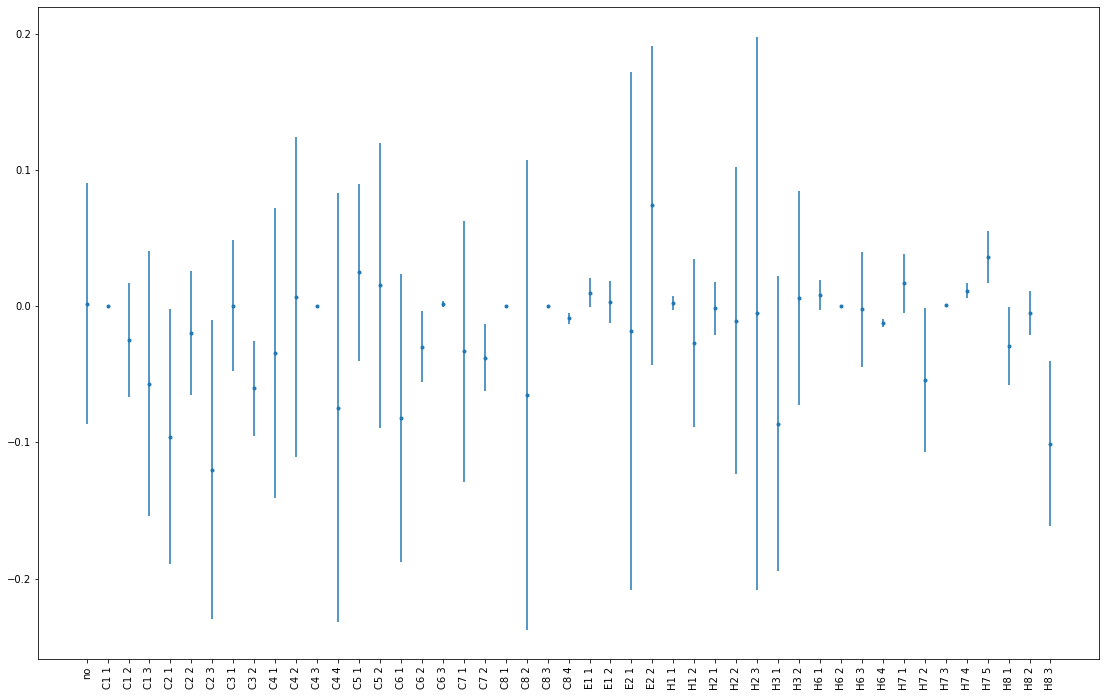

In [ ]:
plot_single_policy(pt, 0)